## Continent-specific tropical PFT Allometries  

#### Libraries

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### CSV files from the  Tallo github:

Main csv with dbh,  height, CA: https://github.com/selva-lab-repo/TALLO/tree/main/DB

Additional csv with biome info: https://github.com/selva-lab-repo/TALLO/tree/main/Jucker%20et%20al.%202022 - (Tallo_environment.csv)

In [2]:
df = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo.csv')
df_env = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_environment.csv')


#### add biome column to main data frame

In [3]:
df_tallo = pd.merge(df, df_env, on='tree_id', how='outer')
#print(df_tallo.head(3))

#### Filter biomes to only keep tropical forest and savanna trees

In [4]:
print(df_tallo['biome'].unique())

['Boreal/montane forest' 'Tropical rain forest'
 'Temperate broadleaf forest' 'Tropical savanna' 'Tropical dry forest'
 'Temperate grassland' 'Temperate conifer forest' 'Mediterranean woodland'
 'Dryland' 'Mangrove']


In [5]:
df_trop = df_tallo.loc[df_tallo['biome'].isin(['Tropical rain forest', 'Tropical savanna', 'Tropical dry forest'])]

#### Filter to only keep angiospermms (FATES doesn't have needleleaf tropical trees)
This discards 1921 trees,  but keeps 174,227

In [6]:
x = df_trop.groupby(['division']).count()
x[['family']]


,family
division,
Angiosperm,174227
Gymnosperm,1921


In [7]:
df_trop = df_trop.loc[df_trop['division'] == 'Angiosperm']

### Drop unused columns and make a crown area column

In [8]:
# only keep relevant columns
keep = ['species', 'latitude', 'longitude', 'stem_diameter_cm', 'height_m', 'height_outlier', 'crown_radius_m', 
       'crown_radius_outlier', 'realm', 'biome', 'family']

df_trop = df_trop[keep]

# make a crown area column
df_trop['crown_area']  = np.pi * df_trop['crown_radius_m']**2 
# rename them 
new_col_names = {'stem_diameter_cm': 'dbh', 'height_m': 'height'}
df_trop.rename(columns=new_col_names, inplace=True)


#### Filter by canopy trees
Only keep species that have a maximum dbh greater 30 cm 

In [9]:
max_dbhs = df_trop.pivot_table(index='species', values='dbh', aggfunc='max')
# get the names of species where max dbh > 30
canopy_species = max_dbhs[max_dbhs['dbh'] > 30]
canopy_names = canopy_species.index

In [10]:
df_trop = df_trop.loc[df_trop['species'].isin(canopy_names)]

### Only keep dominant family 

In [11]:
df1 = (df_trop.groupby('realm')['family'].value_counts()
         .rename('counts').reset_index()
         .drop_duplicates('realm'))
df1

,realm,family,counts
0,Afrotropic,Fabaceae,4180
72,Australasia,Myrtaceae,5742
129,Indo-Malaya,Dipterocarpaceae,6651
211,Neotropic,Fabaceae,7839
285,Oceania,Myrtaceae,489
287,Palearctic,Fagaceae,202


In [12]:
def family_filter(df, family) :
    df = df.loc[df['family'] == family]
    return df

test = [family_filter(d[1], fam) for d,fam in zip(df_trop.groupby('realm'), df1['family'])]    
df_trop = pd.concat(test)

In [13]:
# Save the csv file 
df_trop.to_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv', index=False)


## Martinez-cano height allometry

In [16]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


In [17]:
def fit_d2hmc (df, initial_guess) :
    # remove nas  in dbh and height
    df = df.dropna(subset=['height','dbh'])
    # remove outliers
    df  = df[df['height_outlier']=='N']
   
    height_ps, covariance = curve_fit(f=d2hmc, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                           p0=initial_guess)

    return height_ps 

In [18]:
def  d2hbanin (d, a, b, c) : 
    h  = a - b * np.exp(-c * d)
    return h

In [19]:
def fit_d2hbanin2 (df, initial_guess) :
    # remove nas  in dbh and height
    df = df.dropna(subset=['height','dbh'])
    # remove outliers
    df  = df[df['height_outlier']=='N']
   
    height_ps, covariance = curve_fit(f=d2hbanin, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                           p0=initial_guess)

    return height_ps 

In [20]:
def fit_d2hbanin1(dbhs,  params) : 
    height =  [d2hbanin(d, params[0], params[1], params[2])  for  d  in dbhs]
    return height

### Fit Martinez Cano equation to Tallo data

In [21]:
height_ps_mc = [fit_d2hmc(d[1], initial_guess) for d in df_trop.groupby('realm')]

### Fit Banin equation to Tallo data

In [22]:
initial_guess = [45.08, 42.80, 0.025]
height_ps_b = [fit_d2hbanin2(d[1], initial_guess) for d in df_trop.groupby('realm')]

### Load Banin parameters and calculate those curves

In [23]:
param_ranges_full = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/banin_h_allom_params.csv')

In [24]:
param_ranges_full

,realm,a,b,c
0,Americas,35.83,31.15,0.029
1,Africa,45.08,42.80,0.025
2,Asia,58.25,53.58,0.019
3,Australia,34.97,31.08,0.030


In [25]:
ds = np.arange(1, 250, 1)
banin_americas = fit_d2hbanin1(ds, param_ranges_full[param_ranges_full['realm'] == 'Americas'].values.flatten().tolist()[1:4])
banin_africa = fit_d2hbanin1(ds,  param_ranges_full[param_ranges_full['realm'] == 'Africa'].values.flatten().tolist()[1:4])
banin_asia = fit_d2hbanin1(ds,  param_ranges_full[param_ranges_full['realm'] == 'Asia'].values.flatten().tolist()[1:4])
banin_australia = fit_d2hbanin1(ds, param_ranges_full[param_ranges_full['realm'] == 'Australia'].values.flatten().tolist()[1:4])

#### Plot them 

In [26]:
realms  = df_trop['realm'].unique()

In [27]:
print(realms)

['Afrotropic' 'Australasia' 'Indo-Malaya' 'Neotropic' 'Oceania'
 'Palearctic']


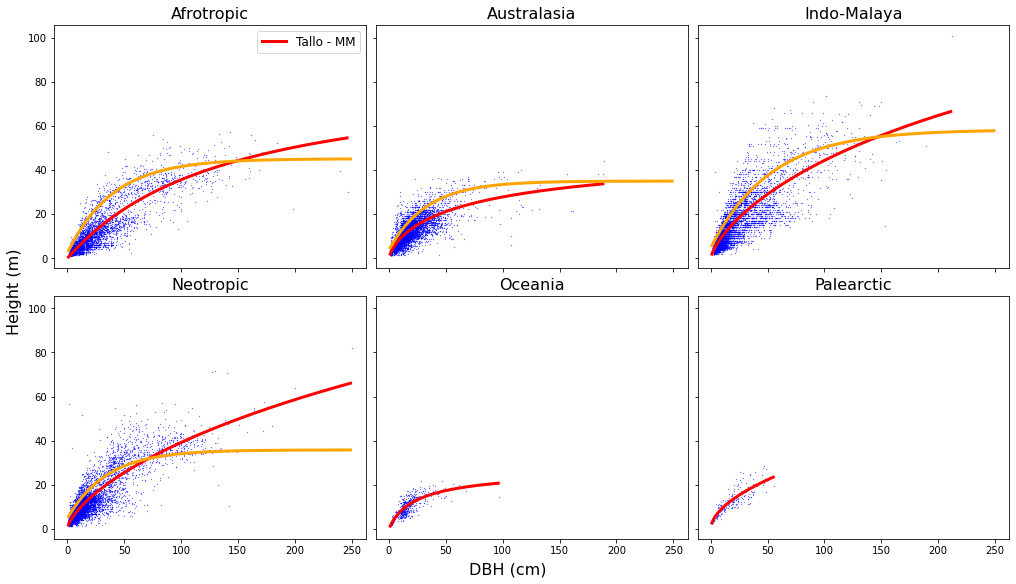

In [29]:
fig1, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms)): 
    realm = realms[i]
    ps_mc = height_ps_mc[i]
    ps_b = height_ps_b[i]
    df = df_trop.loc[df_trop['realm'] == realm]
    dbh = np.arange(1, df['dbh'].max(),1)
    curve_mc = [d2hmc(d, ps_mc[0], ps_mc[1], ps_mc[2])  for  d  in dbh]
    curve_b = [d2hbanin(d, ps_b[0], ps_b[1], ps_b[2])  for  d  in dbh]
    

    axs[i].scatter(df['dbh'], df['height'], s=0.05, color='blue')
    axs[i].plot(dbh, curve_mc, color='red',label='Tallo - MM',linewidth=3.0)
    #axs[i].plot(dbh, curve_b, color='grey',label='Tallo - exponential',linewidth=3.0)
    axs[i].set_title(realm,  fontsize=16)
 
fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)

### add in the banin models
axs[2].plot(ds, banin_asia, color='orange', label='Banin',linewidth=3.0)
axs[3].plot(ds, banin_americas, color='orange',linewidth=3.0)
axs[1].plot(ds, banin_australia, color='orange',linewidth=3.0)
axs[0].plot(ds, banin_africa, color='orange',linewidth=3.0, label='Banin')

axs[0].legend(fontsize=12)